In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append('..')
import functools
import math
import collections

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq
import scipy.stats

from bvbq_torch import distributions,utils
from bvbq_torch import BVBQNamedMixMVN

In [8]:
scipy.stats.gamma(1.0).rvs(size=(10,1))

array([[0.73723084],
       [0.56916511],
       [0.34191307],
       [0.4195417 ],
       [0.05092034],
       [2.39828871],
       [0.03740834],
       [0.02582883],
       [3.08999592],
       [0.56653656]])

In [27]:
def loggaussian(x,mu,sigma):
    return -0.5*((x-mu)/sigma)**2 - np.log(np.sqrt(2*np.pi)*sigma)

def baselogprob(params):
    mu,sigma = params['mu'],params['sigma']
    term1 = np.log(scipy.stats.gamma(3.0).pdf(sigma))
    term2 = loggaussian(mu,0,sigma)
    return term1 + term2

def basesample(n):
    sigma = scipy.stats.gamma(1.0).rvs(size=(n,1))
    mu = np.random.randn(n,1)*sigma
    res = {'mu':mu,'sigma':sigma}
    return res


Text(0, 0.5, 'sigma')

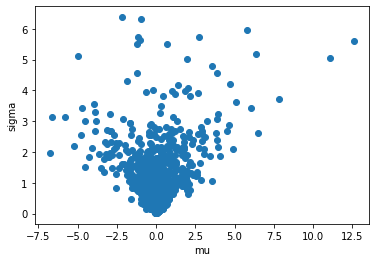

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
samples = basesample(1000)
ax.scatter(samples['mu'],samples['sigma'])
ax.set_xlabel('mu')
ax.set_ylabel('sigma')

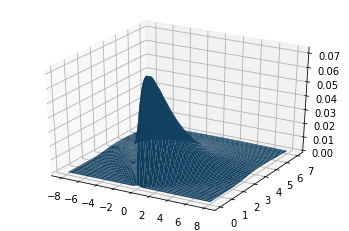

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sigma_plot,mu_plot = np.meshgrid(np.linspace(0,7,101)[1:],np.linspace(-8,8))
params = {'mu':mu_plot,'sigma':sigma_plot}
zplot = baselogprob(params)
ax.plot_surface(mu_plot,sigma_plot,np.exp(zplot))

In [46]:
bvbq = BVBQNamedMixMVN(['mu','sigma'],[1,1],[(None,None),(0.0,None)])

In [57]:
ndata = 50
mu = np.random.randn(ndata,1)
sigma = scipy.stats.gamma(5).rvs(size=(ndata,1))
params_init = {'mu':mu,'sigma':sigma}
params_evals = baselogprob(params_init)
bvbq.initialize_data(params_init,params_evals,empirical_params=True)
bvbq.initialize_components(mean=torch.zeros(2),var=20*torch.ones(2))

In [59]:
for i in range(30):
    bvbq.update_distribution()

In [61]:
distrib = bvbq.distribution

Text(0, 0.5, 'sigma')

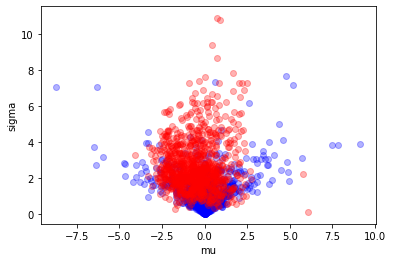

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
samples = basesample(1000)
samples_vb = distrib.sample(1000)
ax.scatter(samples['mu'],samples['sigma'],color='blue',alpha=0.3)
ax.scatter(samples_vb['mu'].numpy(),samples_vb['sigma'].numpy(),color='red',alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')

If tensor has more than 2 dimensions, only diagonal of covariance is returned


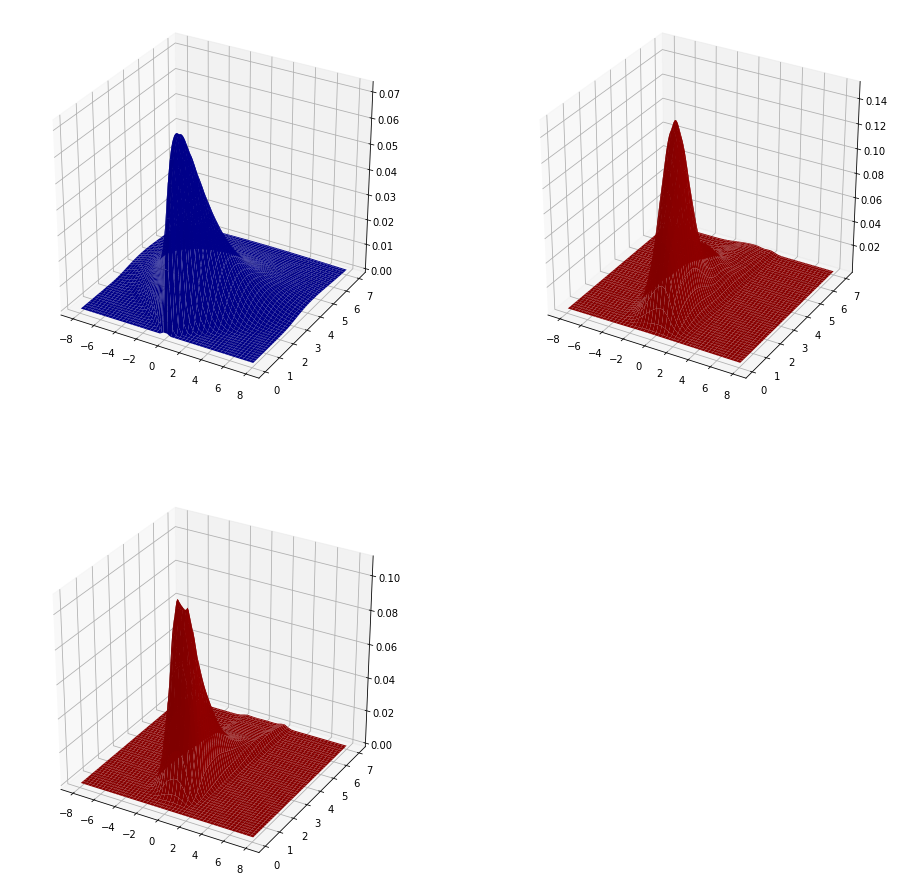

In [80]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221,projection='3d')
ax2 = fig.add_subplot(222,projection='3d')
ax3 = fig.add_subplot(223,projection='3d')
sigma_plot,mu_plot = np.meshgrid(np.linspace(0,7,101)[1:],np.linspace(-8,8))
zplot3 = baselogprob({'mu':mu_plot,'sigma':sigma_plot})
zplot2 = distrib.logprob({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]}).numpy()
zplot3 = bvbq.surrogate_prediction({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]}).numpy()
ax1.plot_surface(mu_plot,sigma_plot,np.exp(zplot),color='blue',alpha=1.0)
ax2.plot_surface(mu_plot,sigma_plot,np.exp(zplot2),color='red',alpha=1.0)
ax3.plot_surface(mu_plot,sigma_plot,np.exp(zplot3),color='red',alpha=1.0)

In [77]:
bvbq.surrogate_prediction({'mu':mu_plot[...,None],'sigma':sigma_plot[...,None]})

If tensor has more than 2 dimensions, only diagonal of covariance is returned


tensor([[-29.8528, -30.4712, -30.8139,  ..., -32.4077, -32.4101, -32.4124],
        [-29.8051, -30.4070, -30.7379,  ..., -32.3026, -32.3059, -32.3091],
        [-29.7390, -30.3181, -30.6327,  ..., -32.1564, -32.1610, -32.1655],
        ...,
        [-29.8792, -30.5068, -30.8558,  ..., -32.0374, -32.0400, -32.0429],
        [-29.9059, -30.5427, -30.8983,  ..., -32.2175, -32.2194, -32.2215],
        [-29.9248, -30.5681, -30.9285,  ..., -32.3472, -32.3485, -32.3500]])